In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

### carga de los datos

In [43]:
without_outliers= pd.read_csv('complete_without_outliers.csv')

In [ ]:
without_outliers.info()

### Limpieza

In [45]:
import gensim # take text for clean and tokenize list of words
from gensim.parsing.preprocessing import STOPWORDS
import nltk
nltk.download('stopwords') #language package for english
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
stop_words = list(stopwords.words("english"))

In [47]:
import gensim
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Inicializamos PorterStemmer
ps = PorterStemmer()

# Cargamos las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Función para limpiar y procesar el texto
def limpiar_texto(text):
    # Verificar si el texto no es nulo o vacío
    if isinstance(text, str):
        # Eliminar saltos de línea y múltiples espacios
        text = re.sub(r'\s+', ' ', text)  # Reemplaza saltos de línea y tabs por un espacio
        text = text.strip()  # Elimina espacios en blanco iniciales y finales

        # Convertir a palabras en minúsculas y filtrar stopwords
        words = [
            ps.stem(word) for word in gensim.utils.simple_preprocess(text)
            if word not in gensim.parsing.preprocessing.STOPWORDS and word not in stop_words
        ]
        return ' '.join(words)
    else:
        return None  # Devuelve None si el texto es inválido

# Aplicar la función de limpieza al DataFrame
without_outliers['text_cleaned'] = without_outliers['text'].apply(limpiar_texto)

# Eliminar filas donde el texto limpio es None o vacío
without_outliers = without_outliers[without_outliers['text_cleaned'].notnull() & (without_outliers['text_cleaned'] != '')]

# Reiniciar el índice del DataFrame después de eliminar las filas
without_outliers.reset_index(drop=True, inplace=True) 



In [48]:
without_outliers.head(4)

,text,class,len_text,text_cleaned
0,Sekhukhune I (Matsebe; circa 1814 – 13 Septemb...,1,1256,sekhukhun matseb circa septemb known sekhukhun...
1,Mount Washington is a peak in the White Mount...,1,628,mount washington peak white mountain new hamps...
2,Acer hillsi is an extinct maple species that w...,1,694,acer hillsi extinct mapl speci endem central a...
3,Derrick George Sherwin (16 April 1936 – 17 Oct...,0,945,derrick georg sherwin april octob english tele...


### train test split

In [49]:
X = without_outliers["text_cleaned"]
y = without_outliers["class"]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Vectorizacion

Es muy recomendable escalar las características (variables X) cuando utilizas un modelo de SVM, ya que este modelo es sensible a las escalas de las características.

¿Por qué?
Los modelos de SVM calculan distancias entre puntos y fronteras de decisión. Si una característica tiene un rango mucho mayor que otra (por ejemplo, una que va de 0 a 1000 y otra que va de 0 a 1), las características de mayor escala dominarán las distancias y afectarán la precisión del modelo.

In [52]:
# Tokenization is necesary for preprocessing text to ML
# We will use CountVectorizer

vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train) # dtm as document-term matrix
X_test_dtm = vect.transform(X_test)

Guardado en .pkl

In [72]:
# Guardar el objeto CountVectorizer en un archivo .pkl
joblib.dump(vect, 'vectorizer.pkl')

print("CountVectorizer guardado en 'vectorizer.pkl'")

CountVectorizer guardado en 'vectorizer.pkl'


### Standarizacion

In [53]:
# Escalar las características de X_train y X_test

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_dtm)
X_test_scaled = scaler.transform(X_test_dtm)

Guardado en pkl

In [73]:
# Guardar el objeto StandardScaler en un archivo .joblib
joblib.dump(scaler, 'standarizer.pkl')

print("StandardScaler guardado en 'standarizer.pkl'")

StandardScaler guardado en 'standarizer.pkl'


### Machine learning models

In [54]:
# Aplicamos primero el modelo Multinomial de Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [55]:
#nb_model = MultinomialNB().fit(X_train_scaled, y_train)

In [56]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Definir el modelo
model_nb = MultinomialNB()

# Definir el rango de hiperparámetros a buscar
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  # Valores para suavizado
    'fit_prior': [True, False],  # Ajustar probabilidades previas
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=model_nb, param_grid=param_grid, cv=5)

# Ajustar el modelo
grid_search.fit(X_train_scaled, y_train)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo
model_nb = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba
pred_nb_model = model_nb.predict(X_test_scaled)

# Calcular la precisión usando el conjunto de prueba
accuracy_nb_1 = model_nb.score(X_test_scaled, y_test)

# Mostrar la precisión
print(f"Precisión del modelo: {accuracy_nb_1:.2f}")

# Generar el reporte de clasificación
print(classification_report(y_test, pred_nb_model))


Mejores hiperparámetros: {'alpha': 0.1, 'fit_prior': True}
Precisión del modelo: 0.53
              precision    recall  f1-score   support

           0       0.53      0.52      0.53     37075
           1       0.53      0.55      0.54     37264

    accuracy                           0.53     74339
   macro avg       0.53      0.53      0.53     74339
weighted avg       0.53      0.53      0.53     74339



In [58]:
# obtenemos la matriz de decisión del primer modelo
from sklearn.metrics import confusion_matrix
matriz1=confusion_matrix(y_test, pred_nb_model)


In [59]:
from tabulate import tabulate

In [60]:

encabezado=['Naive Bayes','AI','Human']
indice=['AI','Human']
print(tabulate(matriz1, headers=encabezado,showindex=indice, tablefmt='fancy_grid'))

╒═══════════════╤═══════╤═════════╕
│ Naive Bayes   │    AI │   Human │
╞═══════════════╪═══════╪═════════╡
│ AI            │ 19407 │   17668 │
├───────────────┼───────┼─────────┤
│ Human         │ 16939 │   20325 │
╘═══════════════╧═══════╧═════════╛


In [61]:
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

<Figure size 800x600 with 0 Axes>

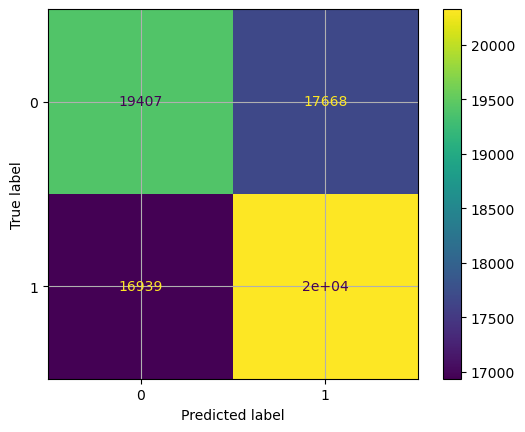

In [62]:
disp = ConfusionMatrixDisplay(confusion_matrix=matriz1)
plt.figure(figsize=(8, 6))
disp.plot(cmap='viridis')  
plt.grid(True)
plt.show()

In [63]:
# Ahora hacemos la agrupación con el segundo modelo, el Support Vector Machine
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV

In [64]:
SS = svm.LinearSVC()

In [65]:
# Para hacer la posterior representación de la curva de ROC, necesitamos obtener las probabilidades, y para ello usamos
# la función CalibratedClassifier
clf_svm = CalibratedClassifierCV(estimator=SS) 

In [66]:
# Ajustamos el modelo y realizamos la predicción
svm_model=clf_svm.fit(X_train_scaled, y_train)
pred_svm_model=svm_model.predict(X_test_scaled)

c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [67]:
# Descomposición de la precisión del segundo modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_svm_model))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82     37075
           1       0.81      0.84      0.82     37264

    accuracy                           0.82     74339
   macro avg       0.82      0.82      0.82     74339
weighted avg       0.82      0.82      0.82     74339



In [68]:
# Matriz de decisión modelo SVM
matriz2=confusion_matrix(y_test, pred_svm_model)
encabezado=['SVM','IA','Human']
indice=['IA','Human']
print(tabulate(matriz2, headers=encabezado,showindex=indice, tablefmt='fancy_grid'))

accuracy_nb=svm_model.score(X_test_scaled, y_test)

╒═══════╤═══════╤═════════╕
│ SVM   │    IA │   Human │
╞═══════╪═══════╪═════════╡
│ IA    │ 29665 │    7410 │
├───────┼───────┼─────────┤
│ Human │  5991 │   31273 │
╘═══════╧═══════╧═════════╛


In [69]:

# Para hacer la comparativa con la curva de ROC, primero tenemos que obtener las probabilidades y después obtenemos los scores
from sklearn.metrics import roc_curve, roc_auc_score

y_score1 = model_nb.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)[:,1]
y_score2 = svm_model.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)

roc1=roc_auc_score(y_test, y_score1)
roc2=roc_auc_score(y_test, y_score2)

c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [70]:
from xgboost import XGBClassifier

In [ ]:
X_train_scaled

In [33]:
# Crear y ajustar el modelo XGBoost para clasificación
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
# Hacer predicciones
pred_xgboost_model = xgboost_model.predict(X_test_scaled)

In [35]:
import joblib

# Guardar el modelo entrenado en un archivo .pkl usando joblib
joblib.dump(xgboost_model, 'xgboost_model_correct.pkl')

['xgboost_model_correct.pkl']

In [36]:
# Evaluación del modelo
accuracy_boost = accuracy_score(y_test, pred_xgboost_model)
print("Accuracy:", accuracy_boost)

Accuracy: 0.8981288421958864


In [37]:
# Metrics for Xgboost

print(classification_report(y_test, pred_xgboost_model))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     37075
           1       0.88      0.92      0.90     37264

    accuracy                           0.90     74339
   macro avg       0.90      0.90      0.90     74339
weighted avg       0.90      0.90      0.90     74339



In [38]:

# Para hacer la comparativa con la curva de ROC, primero tenemos que obtener las probabilidades y después obtenemos los scores
from sklearn.metrics import roc_curve, roc_auc_score

y_score1 = model_nb.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)[:,1]
y_score2 = svm_model.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)[:,1]
y_score3 = xgboost_model.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)[:,1]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, y_score3)

roc1=roc_auc_score(y_test, y_score1)
roc2=roc_auc_score(y_test, y_score2)
roc3=roc_auc_score(y_test, y_score3)

c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


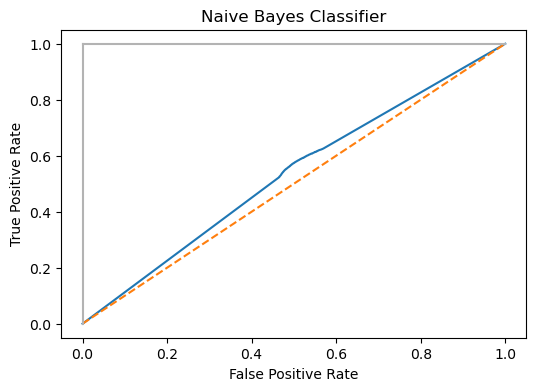

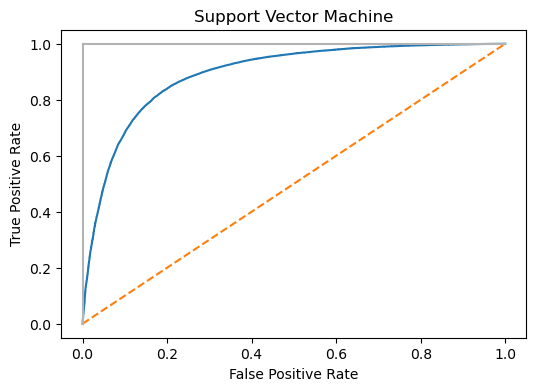

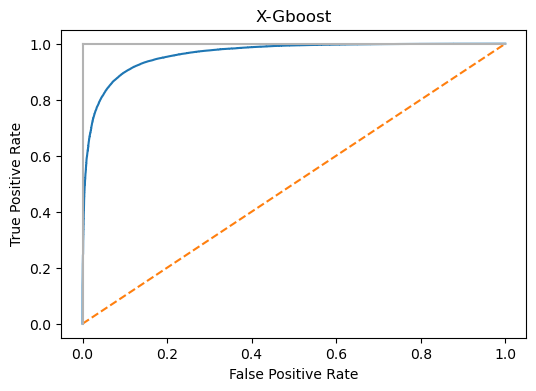

In [39]:
# Graficamos los valores de la curva ROC
plt.subplots(1, figsize=(6,4))
plt.title('Naive Bayes Classifier')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(6,4))
plt.title('Support Vector Machine')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(6,4))
plt.title('X-Gboost')
plt.plot(false_positive_rate3, true_positive_rate3)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:

# Tabla resumen y comparativa entre la precisión y la curva ROC de los dos modelos
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision_mod1=precision_score(y_test, pred_nb_model, average='weighted')
precision_mod2=precision_score(y_test, pred_svm_model, average='weighted')
precision_mod3=precision_score(y_test, pred_xgboost_model, average='weighted')

recall_mod1=recall_score(y_test, pred_nb_model, average='weighted')
recall_mod2=recall_score(y_test, pred_svm_model, average='weighted')
recall_mod3=recall_score(y_test, pred_xgboost_model, average='weighted')

f1_mod1=f1_score(y_test, pred_nb_model, average='weighted')
f1_mod2=f1_score(y_test, pred_svm_model, average='weighted')
f1_mod3=f1_score(y_test, pred_xgboost_model, average='weighted')

summary1=[[precision_mod1,recall_mod1,f1_mod1,roc1],[precision_mod2,recall_mod2,f1_mod2,roc2],[precision_mod3,recall_mod3,f1_mod3,roc3]]
encabezado=['Ratios','Precision','Recall','F1 Score','ROC/AUC']
indice=['Naive Bayes','SVM', 'X-Gboost']
print(tabulate(summary1, headers=encabezado,showindex=indice, tablefmt='fancy_grid'))

╒═════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Ratios      │   Precision │   Recall │   F1 Score │   ROC/AUC │
╞═════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Naive Bayes │    0.534461 │ 0.53447  │   0.534414 │  0.532563 │
├─────────────┼─────────────┼──────────┼────────────┼───────────┤
│ SVM         │    0.820259 │ 0.819812 │   0.819738 │  0.892164 │
├─────────────┼─────────────┼──────────┼────────────┼───────────┤
│ X-Gboost    │    0.898651 │ 0.898129 │   0.89809  │  0.963714 │
╘═════════════╧═════════════╧══════════╧════════════╧═══════════╛
